In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from glob import glob
mype = [pe.withStroke(linewidth=4, foreground='w')]

In [ ]:
f, ax = plt.subplots(1,1, figsize=[4,2])
files =  glob('../exp/prod-adam-run2/analyses/prod/*/*-r1.08/persist.dat')

t, a, b, p = np.mean([np.loadtxt(f) for f in files], axis=0).T
print(a[0],b[0],p[0])
ax.plot(t, a/a[0])
ax.plot(t, b/b[0])
ax.plot(t, p/p[0])
leg = ax.legend(['O-H$_1$', 'N$_1$-H$_1$', 'O-H$_1$-N$_1$'])
# ax.set_xlim(0,50)
ax.set_ylim(-0.1,1.1)
ax.grid(lw=1)
for t in leg.get_texts():
    t.set_path_effects(mype)

ax.set_xlabel('t [ps]', fontsize=11)
ax.set_ylabel('$c_c$(t)', fontsize=11)
plt.savefig('figs/fig3-life.png')

19972.333333333332 2459.6666666666665 12.666666666666666


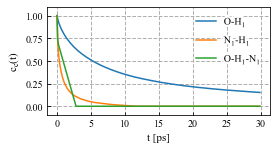

In [32]:
f, ax = plt.subplots(1,1, figsize=[4,2])
files =  glob('../exp/prod-adam-run2/analyses/vali/*-r1.08/persist.dat')

t, a, b, p = np.mean([np.loadtxt(f) for f in files], axis=0).T
print(a[0],b[0],p[0])
ax.plot(t, a/a[0])
ax.plot(t, b/b[0])
ax.plot(t, p/p[0])
leg = ax.legend(['O-H$_1$', 'N$_1$-H$_1$', 'O-H$_1$-N$_1$'])
# ax.set_xlim(0,50)
ax.set_ylim(-0.1,1.1)
ax.grid(lw=1)
for t in leg.get_texts():
    t.set_path_effects(mype)

ax.set_xlabel('t [ps]', fontsize=11)
ax.set_ylabel('$c_c$(t)', fontsize=11)
plt.savefig('figs/fig3-life.png')

[(1100, 11), (1100, 11), (1100, 11)]
[(50000, 11), (50000, 11), (50000, 11)]
[(1000, 11), (1000, 11), (1000, 11)]


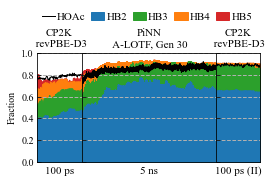

In [37]:
def draw_hb_net(ax, files, window=10):
    hbnet =  [np.loadtxt(data) for data in files]
    print([np.loadtxt(data).shape for data in files])
    hbnet = np.array(hbnet)
    t = hbnet[0,::window,0]
    molperc = hbnet[:,:,1].reshape([hbnet.shape[0],-1,window])/32.
    molperc = molperc.mean(axis=2)
    hbpop = hbnet[:,:,3:].cumsum(axis=2)/64.
    hbpop = hbpop.reshape([hbpop.shape[0],-1,window,hbpop.shape[-1]]).mean(axis=2)
    # axis: sample, time, HBSIZE
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
    l, = ax.plot(t, molperc.mean(axis=0), 'k-', lw=1)
    handles = []
    for x, color in list(zip(hbpop.T, colors))[::-1]:
        h = ax.fill_between(t, x.mean(axis=1), color=color, alpha=1)
        handles.append(h)
    handles.append(l)
    return handles

f, axs = plt.subplots(1,3,gridspec_kw={'width_ratios': [1,3,1], 'wspace':0},
                      figsize=[4,2], sharey=True)
[ax.grid(lw=1) for ax in axs]

files =  glob('../exp/prod-adam-run2/analyses/cp2k/*-rho1.0753/hbnet.dat')
handles = draw_hb_net(axs[0], files)
files =  glob('../exp/prod-adam-run2/analyses/prod/nvt-340k-5ns-0/*-r1.08/hbnet.dat')
draw_hb_net(axs[1], files, window=10)
files =  glob('../exp/prod-adam-run2/analyses/vali/*-r1.08/hbnet.dat')
draw_hb_net(axs[2], files)

axs[0].legend(handles[::-1], 
              ['HOAc']+[f'HB{i+2}' for i in range(len(handles))], 
              loc=3, bbox_to_anchor=[0,1.25],
              handlelength=1.2, ncol=5, fontsize=11,
              columnspacing=0.5, handletextpad=0.2, 
              borderaxespad=0)

[ax.set_xticks([]) for ax in axs]
axs[0].set_xlim(10,110)
axs[1].set_xlim(0,5000)
axs[2].set_xlim(0,100)
axs[0].set_ylim(0,1)
axs[0].set_title('CP2K\n revPBE-D3', fontsize=11)
axs[1].set_title('PiNN\n A-LOTF, Gen 30', fontsize=11)
axs[2].set_title('CP2K\n revPBE-D3', fontsize=11)
axs[0].set_xlabel('100 ps', fontsize=11)
axs[1].set_xlabel('5 ns', fontsize=11)
axs[2].set_xlabel('100 ps (II)', fontsize=11)
axs[0].set_ylabel('Fraction')
plt.savefig('figs/fig4-hbnet.png')